In [1]:
import catboost
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pylab import rcParams

# matplotlib settings
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'

In [2]:
dataset = np.array([[1,4,5,6],[4,5,6,7],[30,40,50,60],[20,15,85,60]])
train_labels = [1.2,3.4,9.5,24.5]

In [3]:
model = CatBoostRegressor(learning_rate=1, depth=6, loss_function='RMSE', logging_level='Verbose') 

## CatBoost Example Usage

### CatBoost Classifier

In [4]:
# initialize data
train_data = np.random.randint(0, 100, size=(100, 10))
train_label = np.random.randint(0, 2, size=(100))
test_data = np.random.randint(0, 100, size=(50, 10))
# specify the training parameters 
model = CatBoostClassifier(iterations=2, depth=2, learning_rate=1, loss_function='Logloss', logging_level='Verbose')
#train the model
model.fit(train_data, train_label, cat_features=[0,2,5])
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("class = ", preds_class)
# print("proba = ", preds_proba)

0: learn: 0.6082712	total: 65.9ms	remaining: 65.9ms
1: learn: 0.5902927	total: 75ms	remaining: 0us
('class = ', array([1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.]))


### CatBoostRegressor 

In [5]:
# initialize data
train_data = np.random.randint(0, 100, size=(100, 10))
train_label = np.random.randint(0, 1000, size=(100))
test_data = np.random.randint(0, 100, size=(50, 10))
# initialize Pool
train_pool = Pool(train_data, train_label, cat_features=[0,2,5])
test_pool = Pool(test_data, cat_features=[0,2,5]) 

# specify the training parameters 
model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)
print(preds)

0: learn: 300.0121	total: 7.9ms	remaining: 7.9ms
1: learn: 285.7313	total: 14.5ms	remaining: 0us
[292.82651321 391.68190537 487.22522379 487.22522379 391.68190537
 388.36983163 504.94336104 391.68190537 409.40004263 299.24803922
 292.82651321 292.82651321 409.40004263 487.22522379 409.40004263
 398.10343137 292.82651321 504.94336104 388.36983163 409.40004263
 487.22522379 631.20343137 391.68190537 648.92156863 631.20343137
 487.22522379 648.92156863 487.22522379 409.40004263 292.82651321
 292.82651321 391.68190537 398.10343137 388.36983163 409.40004263
 409.40004263 415.82156863 631.20343137 631.20343137 292.82651321
 409.40004263 391.68190537 409.40004263 292.82651321 388.36983163
 487.22522379 648.92156863 487.22522379 532.34803922 292.82651321]


### Loading the data

In [6]:
train = pd.read_csv('../data/train.csv', index_col = 'id')
test = pd.read_csv('../data/test.csv', index_col = 'id')
train.head(2)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000


In [7]:
macro = pd.read_csv('../data/macro.csv')
macro.head(2)

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [8]:
df_train = pd.merge(train, macro, on = 'timestamp')
df_test = pd.merge(test, macro, on = 'timestamp')
df_train.head(2)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


### Data cleaning

In [9]:
df_train = df_train[df_train.full_sq < 5000]
df_train = df_train[df_train.life_sq < 5000]
df_train = df_train[(df_train.build_year < 2017) & (df_train.build_year > 1700)]

### Exploratory Data Analysis
#### Year train/test distribution

In [10]:
def split_timestamp(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    df['day'] = df.timestamp.dt.day
    df['month'] = df.timestamp.dt.month
    df['year'] = df.timestamp.dt.year
    df['quarter'] = np.ceil(df['month'] / 3).astype(int)

split_timestamp(df_train)
split_timestamp(df_test)

In [11]:
year_train_distr = df_train.groupby(by = 'year')['timestamp'].count()
year_test_distr = df_test.groupby(by = 'year')['timestamp'].count()

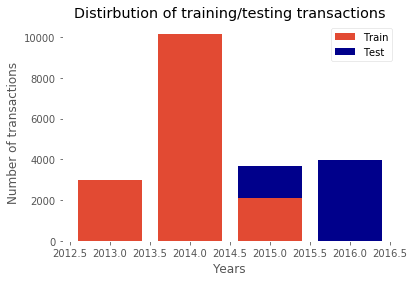

In [12]:
fig = plt.figure()
p1 = plt.bar(year_test_distr.index, year_test_distr, color='darkblue')
p2 = plt.bar(year_train_distr.index, year_train_distr)
plt.xlabel('Years')
plt.ylabel('Number of transactions')
plt.title('Distirbution of training/testing transactions')
plt.legend((p2[0], p1[0]), ('Train', 'Test'))
plt.show()

#### Median price changes

In [13]:
price_train_distr = df_train.groupby(['year', 'quarter'])['price_doc'].median().reset_index()
price_train_distr['quarter_year'] = price_train_distr[['quarter', 'year']].apply(lambda (x, y): 
                                                                             str(x) + '-' + str(y), axis=1)
price_train_distr.head(2)

,year,quarter,price_doc,quarter_year
0,2013,2,6837500,2-2013
1,2013,3,6600000,3-2013


In [14]:
df_train['price_sq_m'] = df_train['price_doc'] / df_train['full_sq']
price_sq_m_train_distr = df_train.groupby(['year', 'quarter'])['price_sq_m'].median().reset_index()
price_sq_m_train_distr['quarter_year'] = price_sq_m_train_distr[['quarter', 'year']].apply(lambda (x, y): 
                                                                             str(x) + '-' + str(y), axis=1)
price_sq_m_train_distr.head(2)

,year,quarter,price_sq_m,quarter_year
0,2013,2,158576.388889,2-2013
1,2013,3,150000.000000,3-2013


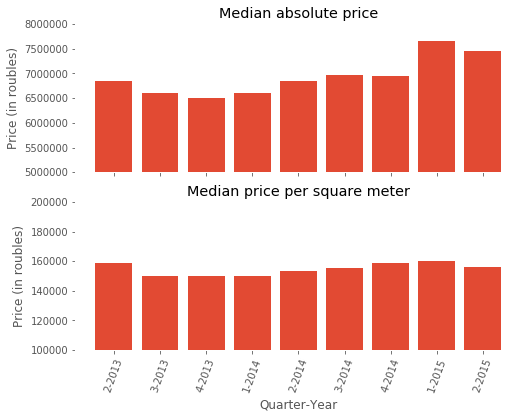

In [15]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8, 6))
ax[0].bar(range(0, len(price_train_distr)), price_train_distr.price_doc)
ax[0].set_ylim(5e+6, 8e+6)
ax[0].set_xticks(range(0, len(price_train_distr)))
ax[0].set_xticklabels(price_train_distr.quarter_year, rotation=70)
ax[0].set_title('Median absolute price')
ax[0].set_ylabel('Price (in roubles)')


ax[1].bar(range(0, len(price_sq_m_train_distr)), price_sq_m_train_distr.price_sq_m)
ax[1].set_ylim(1e+5, 2e+5)
ax[1].set_xticks(range(0, len(price_sq_m_train_distr)))
ax[1].set_xticklabels(price_sq_m_train_distr.quarter_year, rotation=70)
ax[1].set_title('Median price per square meter')
ax[1].set_ylabel('Price (in roubles)')
ax[1].set_xlabel('Quarter-Year')

plt.show()

#### Price dependency on total and living areas in square meters

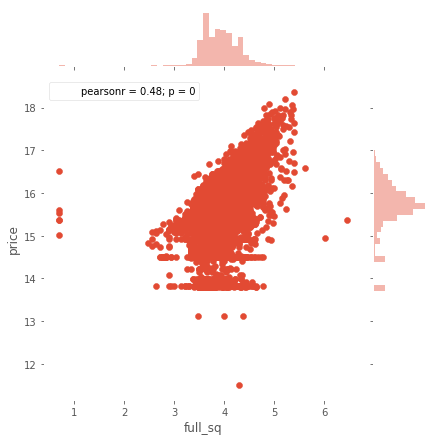

In [16]:
sns.jointplot(x=np.log1p(df_train.full_sq.values), y=np.log1p(df_train.price_doc.values)) \
   .set_axis_labels('full_sq', 'price')
plt.show()

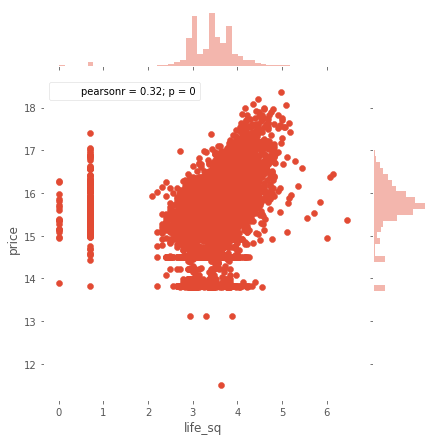

In [17]:
sns.jointplot(x=np.log1p(df_train.life_sq.values), y=np.log1p(df_train.price_doc.values)) \
   .set_axis_labels('life_sq', 'price')
plt.show()

#### Floor and room number distribution

In [18]:
floor_unique = sorted(df_train.floor.dropna().unique())

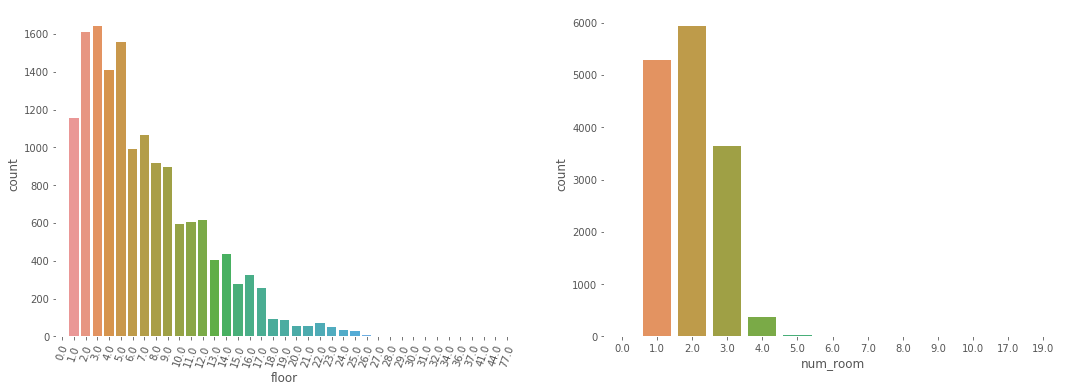

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.countplot(x = "floor", data=df_train, ax = ax[0])
sns.countplot(x = "num_room", data = df_train, ax = ax[1])
ax[0].set_xticklabels(floor_unique, rotation=70)
plt.show()

#### Price difference between flats for Investment and for OwnerOccupiers

In [20]:
invest = df_train[df_train.product_type == 'Investment']
owner = df_train[df_train.product_type == 'OwnerOccupier']

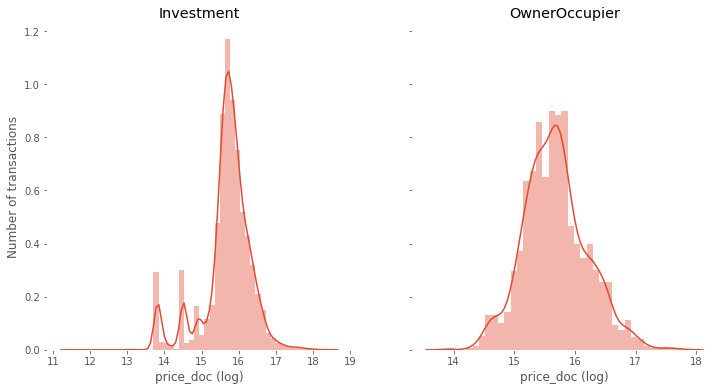

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
sns.distplot(np.log1p(invest.price_doc), ax = ax[0], axlabel = 'price_doc (log)')
sns.distplot(np.log1p(owner.price_doc), ax = ax[1], axlabel = 'price_doc (log)')
ax[0].set_title('Investment')
ax[1].set_title('OwnerOccupier')
ax[0].set_ylabel('Number of transactions')
plt.show()

#### Build year distribution 

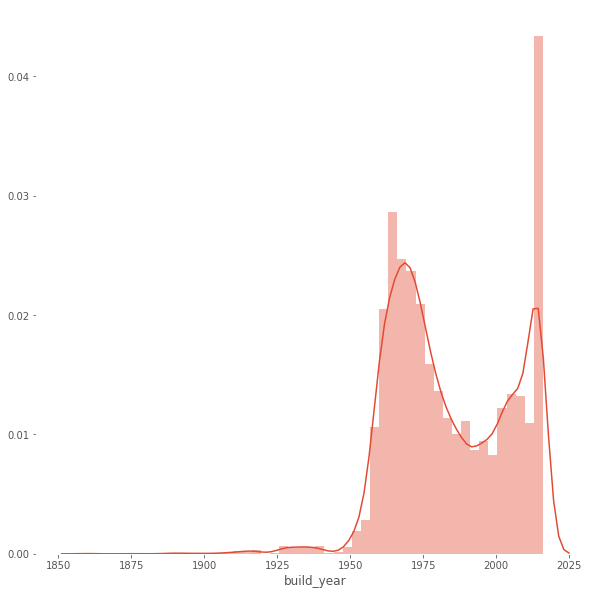

In [22]:
plt.figure(figsize=(10, 10))
sns.distplot(df_train.build_year.dropna())
plt.show()